# ST446 Distributed Computing for Big Data
## Seminar class 8: Scalable machine learning II


# Matrix completion via ALS: movie recommendations example

In this notebook, we demonstrate how to train a recommendation system model based on matrix completion in PySpark by minimizing a loss function through the Alternating Least Square (ALS) algorithm. 

Before running this notebook, please have a look at the moovielens dataset, download the movie ratings datasets _ml-latest-small.zip_ and _ml-lates.zip_ from https://grouplens.org/datasets/movielens/latest/ and upload it into HDFS.

I downloaded the large (~ 250 MB) and the small file and copied them into hdfs using commands like these (on the remote machine):
```
$ wget http://files.grouplens.org/datasets/movielens/ml-latest.zip
$ unzip ml-latest.zip 
$ hadoop fs -put ~/ml-latest/ /
$ hadoop fs -ls /
Found 5 items
drwxr-xr-x   - fluid  hadoop          0 2019-03-11 11:07 /fluid
drwx------   - mapred hadoop          0 2019-03-11 10:58 /hadoop
drwxr-xr-x   - fluid  hadoop          0 2019-03-11 11:07 /ml-latest
drwxrwxrwt   - hdfs   hadoop          0 2019-03-11 10:58 /tmp
drwxrwxrwt   - hdfs   hadoop          0 2019-03-11 11:04 /user
```
and likewise for `ml-latest-small.zip`.

Note that the alternative of uploading these files to a bucket could take a while.

### Have a look at the data:
```
$ head ratings.csv 
userId,movieId,rating,timestamp
1,307,3.5,1256677221
1,481,3.5,1256677456
1,1091,1.5,1256677471
1,1257,4.5,1256677460
1,1449,4.5,1256677264
1,1590,2.5,1256677236
1,1591,1.5,1256677475
1,2134,4.5,1256677464
1,2478,4.0,1256677239

$ head movies.csv 
movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
```

We're going to use the test data set first.


Recall that we are going to approximate a matrix of ratings $A \in \mathbb{R}^{m\times n}$ as a low-rank matrix $X Y^\top$,  where $X \in \mathbb{R}^{m\times r}$ and $Y \in \mathbb{R}^{n\times r}$. Here, $m$ is the number of users, $n$ is the number of movies and $r \ll m,n$ is the number of latent factors, that is, the rank of the approximation of $A$.



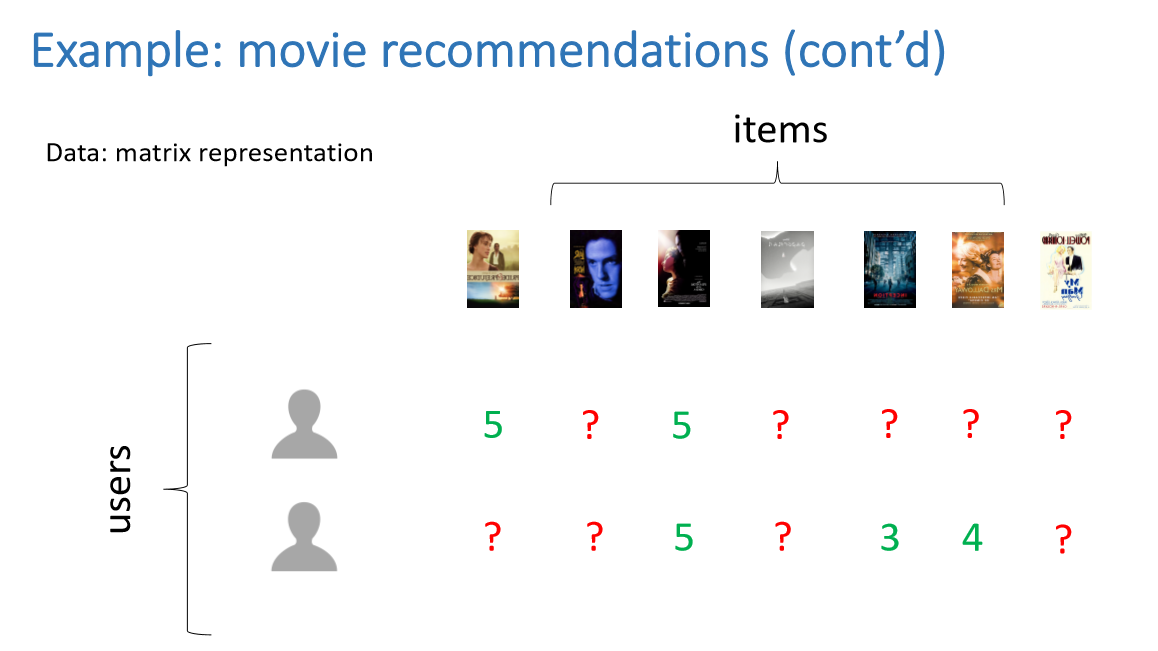

In [1]:
# To display these images in Google Colab, you should i) upload all PNG files to your Google Colab 
# folder and ii) adjust the path (eg /content/sample_data/)

from IPython.display import Image
Image(filename='./figs/ALS-1.png')

## Load data

In [ ]:
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# please update the folder to point to your folder in hdfs
folder = "hdfs:///ml-latest-small/"
# folder = "hdfs:///ml-latest/" # for full data set

rating_schema = StructType([
    StructField("userId", LongType(), True),    
    StructField("movieId", LongType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

ratings = spark.read.csv(folder+"ratings.csv", header=True, schema=rating_schema)

for x in ratings.head(4):
  print(x) 

Row(userId=1, movieId=1, rating=4.0, timestamp=964982703)
Row(userId=1, movieId=3, rating=4.0, timestamp=964981247)
Row(userId=1, movieId=6, rating=4.0, timestamp=964982224)
Row(userId=1, movieId=47, rating=5.0, timestamp=964983815)


In [ ]:
# split the data to training and test parts
(training, test) = ratings.randomSplit([0.8, 0.2], seed=10)
training.cache()
test.cache()
print('Number of partitions: ', training.rdd.getNumPartitions())
print('Number of workers:', sc._conf.get('spark.executor.instances'))

Number of partitions:  1
Number of workers: 2


## Build the recommendation system model using ALS

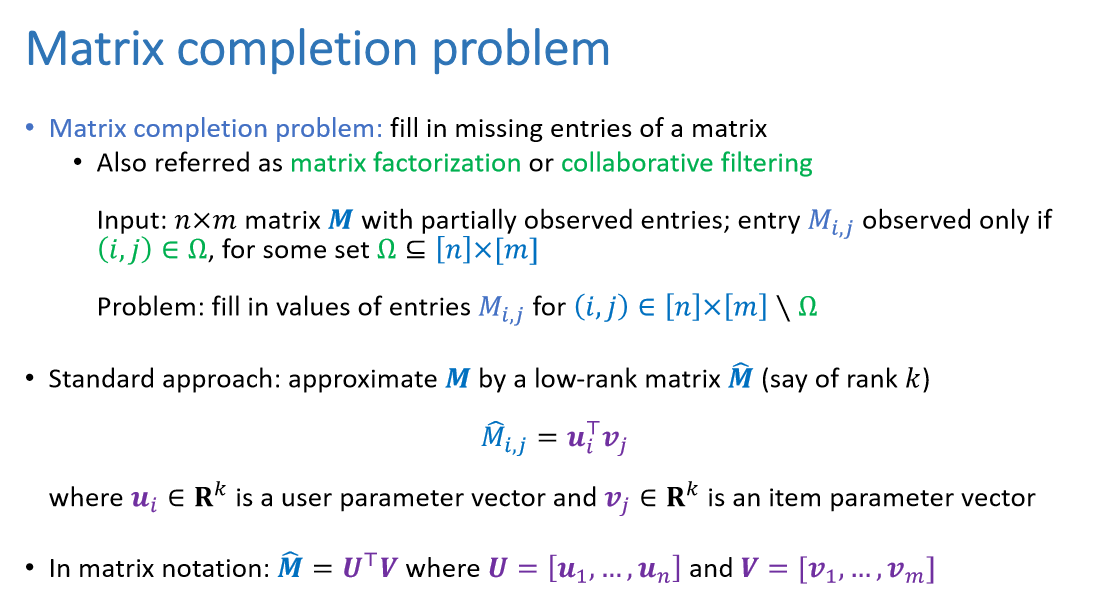

In [3]:
from IPython.display import Image
Image(filename='./figs/ALS-2.png')

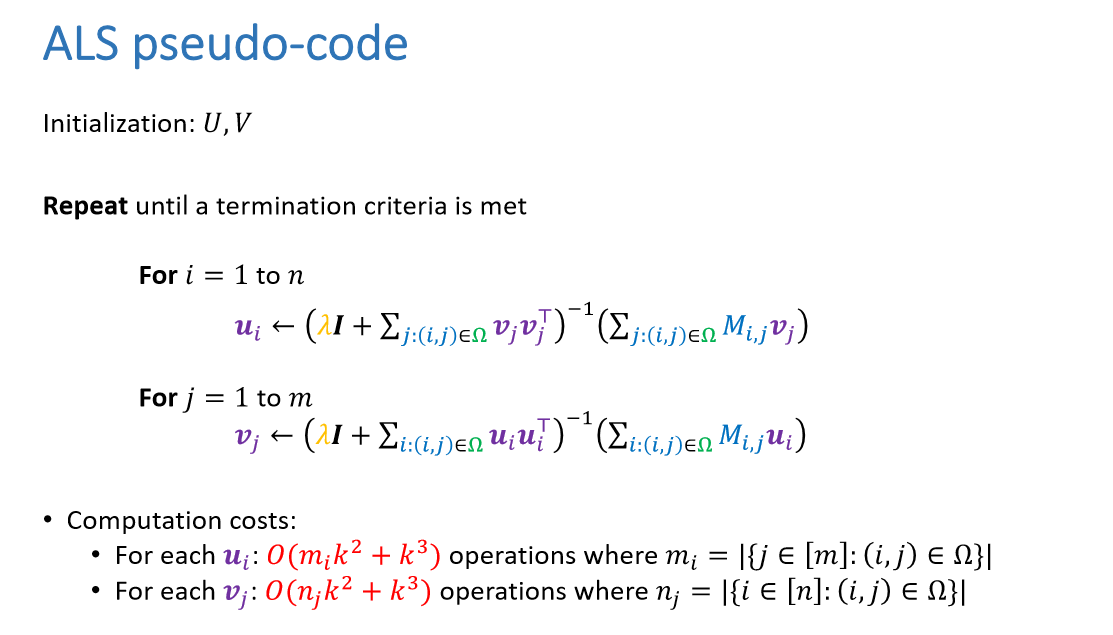

In [4]:
from IPython.display import Image
Image(filename='./figs/ALS-3.png')

In the following cell, the coldStartStrategy is set to `drop` to ensure that we don't get NaN evaluation metrics, if there is an unseen user or an unseen movie. 

See here about the cold start strategy: https://people.apache.org/~pwendell/spark-nightly/spark-master-docs/latest/ml-collaborative-filtering.html#cold-start-strategy

In [ ]:
numberLatentFactors = 5 # specify how many latent factors to use (default is 10)
als = ALS(rank=numberLatentFactors, maxIter=5, regParam=0.01, 
          userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")

model = als.fit(training)
# note that running the training on the full data set takes a while!

## Evaluate the model

In [ ]:
# Evaluate the model by computing the RMSE on the test data

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="rating", predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9905893400742061


## How many factors and iterations to choose?
Let's have a look a the impact of the number of latent factors and maximum number of training iterations (don't try do run this on the large dataset!)

In [ ]:
rmserrors = {}
for numberLatentFactors in range(1,11):
    for maxIterations in range(5,11):
        als = ALS(rank=numberLatentFactors, maxIter=maxIterations, regParam=0.01, 
          userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")

        model = als.fit(training)
    
        predictions = model.transform(test)

        evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="rating", predictionCol="prediction")

        rmse = evaluator.evaluate(predictions)
        
        print("latent factors: ", numberLatentFactors)
        print("max iterations: ", maxIterations)
        rmserrors[(numberLatentFactors,maxIterations)] = rmse

        print("Root-mean-square error = " + str(rmse))

latent factors:  1
max iterations:  5
Root-mean-square error = 1.6943852026513255
latent factors:  1
max iterations:  6
Root-mean-square error = 1.3793417356459676
latent factors:  1
max iterations:  7
Root-mean-square error = 1.292418119057368
latent factors:  1
max iterations:  8
Root-mean-square error = 1.2950649826534708
latent factors:  1
max iterations:  9
Root-mean-square error = 1.3092807292131123
latent factors:  1
max iterations:  10
Root-mean-square error = 1.3205810232498059
latent factors:  2
max iterations:  5
Root-mean-square error = 0.964600878645224
latent factors:  2
max iterations:  6
Root-mean-square error = 0.9416666458299285
latent factors:  2
max iterations:  7
Root-mean-square error = 0.9389320403417312
latent factors:  2
max iterations:  8
Root-mean-square error = 0.9374082743682246
latent factors:  2
max iterations:  9
Root-mean-square error = 0.9373181686589772
latent factors:  2
max iterations:  10
Root-mean-square error = 0.9403595826758322
latent factors: 

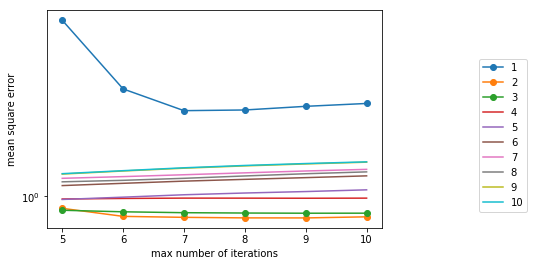

In [ ]:
#### plotting ####
from matplotlib import pyplot as plt
%matplotlib inline

# unique entries:
maxiter = list(set([x[1] for x in rmserrors.keys()]))
numberLatentFactors = list(set([x[0] for x in rmserrors.keys()]))

for numberLatentFactors in range(1,11):
    currenrmse = [rmserrors[numberLatentFactors,m] for m in maxiter]
    if numberLatentFactors in [1,2,3]:
        plt.plot(maxiter,currenrmse,'o-',label=numberLatentFactors)
    else:
        plt.plot(maxiter,currenrmse,label=numberLatentFactors)
    plt.xlabel('max number of iterations')
    plt.ylabel('mean square error')
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8))
plt.show()

It looks like 2 latent factors are doing a good job here. Large numbers of factors or iteration counts do not seem to help all that much, but increase overfitting (for our small data set).

**Homework: Will this change, if you include stronger regularisation? Loop over a few values for the regularisation parameter and few values of the number of latent factors to get a similar graph to the one below).**

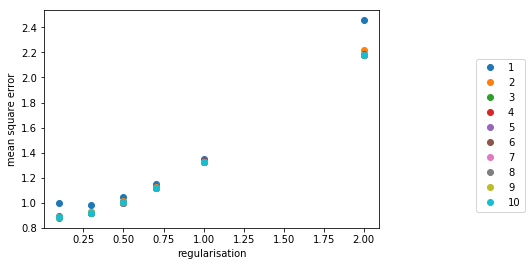

In [ ]:
# your code. my plot looked something like this:

In [ ]:
als = ALS(rank=2, maxIter=8, regParam=0.01, 
          userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")

model = als.fit(training)

## Recommendations
Let's look at some of the predictions we have generated.

In [ ]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [ ]:
userRecs.show()

movieRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[4518, 12.14519]...|
|   471|[[70946, 8.451179...|
|   463|[[4518, 9.926472]...|
|   496|[[4518, 9.125513]...|
|   540|[[4518, 11.83913]...|
|   392|[[5181, 13.392995...|
|   243|[[70946, 12.05647...|
|    31|[[4518, 15.930488...|
|   516|[[4518, 14.020818...|
|   580|[[4518, 12.466761...|
|   251|[[4518, 10.624662...|
|   451|[[70946, 11.76740...|
|    85|[[4518, 11.635759...|
|   137|[[484, 8.252415],...|
|    65|[[4518, 12.219793...|
|   458|[[4518, 18.430695...|
|   588|[[5919, 7.6203976...|
|   481|[[4518, 11.847674...|
|    53|[[4518, 14.653845...|
|   255|[[4518, 20.144394...|
+------+--------------------+
only showing top 20 rows

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1580|[[53, 4.9620175],...|
|   4900|[[55, 11.967562],...|
|   5300|[[291, 5.490572],...|
|   6620|[[55, 7.296524], ...|
|   7340|[[485, 7.8186564]...|
|  324

## Analysis of the recommendation results for a specific user

### Get the titles and genres of movies

In [ ]:
movie_schema = StructType([
    StructField("movieId", LongType(), True),    
    StructField("title", StringType(), True),
    StructField("genre", StringType(), True)
])

movies = spark.read.csv(folder+"movies.csv", header=True, schema=movie_schema)

for x in movies.head(4):
  print(x) 

Row(movieId=1, title='Toy Story (1995)', genre='Adventure|Animation|Children|Comedy|Fantasy')
Row(movieId=2, title='Jumanji (1995)', genre='Adventure|Children|Fantasy')
Row(movieId=3, title='Grumpier Old Men (1995)', genre='Comedy|Romance')
Row(movieId=4, title='Waiting to Exhale (1995)', genre='Comedy|Drama|Romance')


### Check the movies rated by a user

In [ ]:
#user_id = [i[0] for i in userRecs.select("userId").collect()]

user_id = userRecs.select("userId").take(1)[0][0]

user_rating = ratings.filter(ratings.userId.isin(user_id))

high_user_movie_id = [i[0] for i in user_rating.select("movieId").filter(ratings.rating == 5).collect()]

low_user_movie_id = [i[0] for i in user_rating.select("movieId").filter(ratings.rating <= 2).collect()]

In [ ]:
print(high_user_movie_id)
print(low_user_movie_id)

[30816, 40629, 98491]
[79132]


### Check the highest rated movies by this user

In [ ]:
movies.select("title").filter(movies.movieId.isin(high_user_movie_id)).collect()

[Row(title='Phantom of the Opera, The (2004)'),
 Row(title='Pride & Prejudice (2005)'),
 Row(title='Paperman (2012)')]

In [ ]:
recommended_movie = userRecs.filter(userRecs.userId.isin(user_id))

recommended_movie_id = [i[0] for i in recommended_movie.select("recommendations").collect()[0][0]]

### Check the lowest rated movies

In [ ]:
movies.select("title").filter(movies.movieId.isin(low_user_movie_id)).collect()

[Row(title='Inception (2010)')]

### Check the recommended movies

In [ ]:
recommended_movie = userRecs.filter(userRecs.userId.isin(user_id))

recommended_movie_id = [i[0] for i in recommended_movie.select("recommendations").collect()[0][0]]

In [ ]:
movies.select("title").filter(movies.movieId.isin(recommended_movie_id)).collect()

[Row(title='My Man Godfrey (1936)'),
 Row(title='Mrs. Dalloway (1997)'),
 Row(title='The Lair of the White Worm (1988)'),
 Row(title='Looker (1981)'),
 Row(title='Android (1982)'),
 Row(title='Master of the Flying Guillotine (Du bi quan wang da po xue di zi) (1975)'),
 Row(title='Death Race 2000 (1975)'),
 Row(title='All of Me (1984)'),
 Row(title='Clonus Horror, The (1979)'),
 Row(title='Grown Ups 2 (2013)')]

In [ ]:
[i[1] for i in recommended_movie.select("recommendations").collect()[0][0]]

[12.145190238952637,
 11.635612487792969,
 9.242158889770508,
 8.631134033203125,
 7.631368637084961,
 7.274921894073486,
 7.264993667602539,
 7.264993667602539,
 7.264993667602539,
 7.225142478942871]

# How about training on the large data set?
Let's run the training on the large data set to see how resource intensive training with ALS can get.

In [ ]:
folder = "hdfs:///ml-latest/" 

rating_schema = StructType([
    StructField("userId", LongType(), True),    
    StructField("movieId", LongType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

ratings = spark.read.csv(folder+"ratings.csv", header=True, schema=rating_schema)

for x in ratings.head(4):
  print(x) 

Row(userId=1, movieId=307, rating=3.5, timestamp=1256677221)
Row(userId=1, movieId=481, rating=3.5, timestamp=1256677456)
Row(userId=1, movieId=1091, rating=1.5, timestamp=1256677471)
Row(userId=1, movieId=1257, rating=4.5, timestamp=1256677460)


In [ ]:
# split the data to training and test parts
(training, test) = ratings.randomSplit([0.7, 0.3], seed=10)
training.cache()
test.cache()
print('Number of partitions: ', training.rdd.getNumPartitions())
print('Number of workers:', sc._conf.get('spark.executor.instances'))

Number of partitions:  6
Number of workers: 2


Note that we are now automatically using more partitions!

The training below should take some time to run. If you monitor the CPU usage on the workers (you can check this by connecing to a worker through `ssh` and running `top`), you should see several processes that require multiple threads:

```
  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND                                          
 8104 yarn      21   1 8040464 3.430g  50588 S 198.7 23.3  15:22.39 java                                             
 9200 yarn      21   1 8034636 3.477g  50600 S 198.7 23.7  15:24.15 java      
 ...
```


In [ ]:
for numberLatentFactors in [2,5]:
    als = ALS(rank=numberLatentFactors, maxIter=6, regParam=0.01, 
      userCol="userId", itemCol="movieId", ratingCol="rating", 
      coldStartStrategy="drop")

    model = als.fit(training)

    predictions = model.transform(test)

    evaluator = RegressionEvaluator(metricName="rmse", 
                            labelCol="rating", predictionCol="prediction")

    rmse = evaluator.evaluate(predictions)

    print("latent factors: ", numberLatentFactors)
    rmserrors[(numberLatentFactors)] = rmse
    print("Root-mean-square error: ", rmse)
    print("\n")

latent factors:  2
Root-mean-square error:  0.8569316356029683


latent factors:  5
Root-mean-square error:  0.8400232653607848




This might take a couple of minutes.

For the larger data set, it seems that using more factors was a good idea.

For the definition of the RMSE, have a look here:
https://people.apache.org/~pwendell/spark-nightly/spark-master-docs/latest/mllib-evaluation-metrics.html#regression-model-evaluation